In [1]:
import pandas as pd
pd.set_option('display.max_rows', None)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Carga de datos

In [2]:
train_data = pd.read_csv("spaceship-titanic/train.csv")
print(train_data.shape)
train_data.head(3)

(8693, 14)


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False


In [3]:
train_data.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

## Valores faltantes

In [4]:
train_data.isna().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

## Valores repetidos y únicos

In [5]:
train_data.nunique()

PassengerId     8693
HomePlanet         3
CryoSleep          2
Cabin           6560
Destination        3
Age               80
VIP                2
RoomService     1273
FoodCourt       1507
ShoppingMall    1115
Spa             1327
VRDeck          1306
Name            8473
Transported        2
dtype: int64

Cada pasagero tiene un `PassengerId` único, sin embargo hay algunos nombres que se repiten. También, varios pasageros comparten `Cabin`.

## Análisis de correlación

In [6]:
train_data.corr(numeric_only=True).style.background_gradient('viridis')

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
Age,1.000000,0.068723,0.130421,0.033133,0.123970,0.101007,-0.075026
RoomService,0.068723,1.000000,-0.015889,0.054480,0.010080,-0.019581,-0.244611
FoodCourt,0.130421,-0.015889,1.000000,-0.014228,0.221891,0.227995,0.046566
ShoppingMall,0.033133,0.054480,-0.014228,1.000000,0.013879,-0.007322,0.010141
Spa,0.123970,0.010080,0.221891,0.013879,1.000000,0.153821,-0.221131
VRDeck,0.101007,-0.019581,0.227995,-0.007322,0.153821,1.000000,-0.207075
Transported,-0.075026,-0.244611,0.046566,0.010141,-0.221131,-0.207075,1.000000


# Análisis univariante y multivariante

## PassengerId

A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. **People in a group are often family members, but not always.**

In [7]:
passengersInfo = train_data.PassengerId.apply( lambda gggg_pp : pd.Series(index=['PassengerGroup','PassengerGroupNum'],
                                                                          data=[gggg_pp.split('_')[0], gggg_pp.split('_')[1]]) )
train_data = train_data.merge(passengersInfo, how='inner', left_index=True, right_index=True)
train_data.head(3)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,PassengerGroup,PassengerGroupNum
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0001,01
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,0002,01
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,0003,01


In [8]:
train_data.PassengerGroup.min(), train_data.PassengerGroup.max()

('0001', '9280')

In [9]:
train_data.PassengerGroupNum.min(), train_data.PassengerGroupNum.max()

('01', '08')

In [10]:
train_data.loc[ train_data.PassengerGroupNum=='08', 'PassengerGroup' ].unique()

array(['0984', '4005', '4256', '4498', '5133', '5756', '5885', '8168',
       '8728', '8796', '8956', '8988', '9081'], dtype=object)

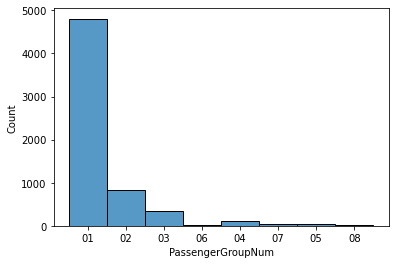

In [11]:
sns.histplot( train_data.groupby('PassengerGroup')['PassengerGroupNum'].max() );

Quizás se pueda extraer una variable que clasifique los grupos en función del tamaño.

In [12]:
group_size = train_data.groupby('PassengerGroup')[['PassengerGroupNum']].max().rename(columns={'PassengerGroupNum':'GroupSize'}).reset_index()
train_data = train_data.merge(group_size, how='left', on='PassengerGroup')

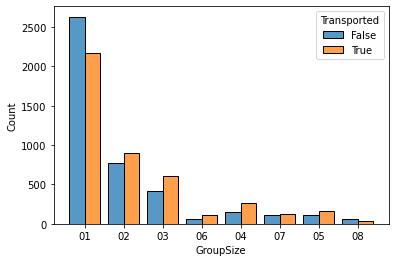

In [13]:
sns.histplot(data=train_data, x='GroupSize', hue='Transported', multiple='dodge', shrink=.8);

Salvo en grupos de tamaño 1 y 8, en el resto de grupos hay más pasajeros perdidos que no transportados.

## HomePlanet

The planet the passenger departed from, typically their planet of permanent residence.

In [14]:
train_data.HomePlanet.value_counts(dropna=False)

Earth     4602
Europa    2131
Mars      1759
NaN        201
Name: HomePlanet, dtype: int64

In [15]:
train_data.HomePlanet.fillna("Ns/Nc", inplace=True)

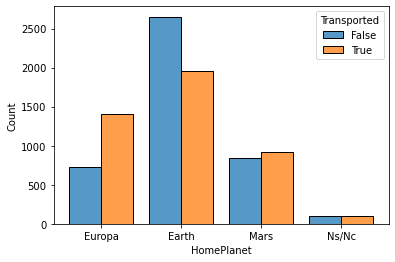

In [16]:
sns.histplot(train_data, x='HomePlanet', hue='Transported', multiple='dodge', shrink=.8);

Solo entre los pasajeros provenientes de la Tierra hay menos cantidad de pasajeros que se pierden.

## CryoSleep

Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.

In [17]:
train_data.CryoSleep.value_counts(dropna=False)

False    5439
True     3037
NaN       217
Name: CryoSleep, dtype: int64

In [18]:
train_data['CryoSleep'] = train_data.CryoSleep.astype('string').fillna('Ns/Nc')

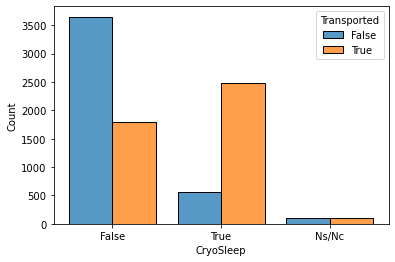

In [19]:
sns.histplot(train_data, x='CryoSleep', hue='Transported', multiple='dodge', shrink=.8);

En esta variable se hace mucho más obvio que los pasajeros que iban dormidos tenían muchas más posibilidades de perderse.

## Cabin

The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.

In [20]:
passengersInfo = train_data.Cabin.apply( lambda cabin : pd.Series(index=['CabinDeck','CabinNum','CabinSide'],
                                                                  data=[cabin.split('/')[0], cabin.split('/')[1], cabin.split('/')[2]]) if pd.notna(cabin)\
                                         else pd.Series(index=['CabinDeck','CabinNum','CabinSide'], data=["Ns/Nc",np.nan,"Ns/Nc"]) )
train_data = train_data.merge(passengersInfo, how='inner', left_index=True, right_index=True)
train_data.head(3)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,PassengerGroup,PassengerGroupNum,GroupSize,CabinDeck,CabinNum,CabinSide
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0001,01,01,B,0,P
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,0002,01,01,F,0,S
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,0003,01,02,A,0,S


In [21]:
train_data.CabinDeck.value_counts(dropna=False)

F        2794
G        2559
E         876
B         779
C         747
D         478
A         256
Ns/Nc     199
T           5
Name: CabinDeck, dtype: int64

In [37]:
train_data.groupby('VIP')['CabinDeck'].value_counts(dropna=False)

VIP    CabinDeck
False  F            2695
       G            2493
       E             846
       B             725
       C             687
       D             438
       A             215
       Ns/Nc         187
       T               5
True   B              42
       C              41
       A              35
       D              31
       F              29
       E              15
       Ns/Nc           6
Name: CabinDeck, dtype: int64

'G' y 'T' son las únicas `CabinDeck` que no tienen pasageros VIP. No está clara la relación entre estas 2 variables.

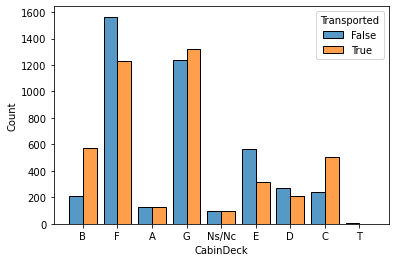

In [22]:
sns.histplot(train_data, x='CabinDeck', hue='Transported', multiple='dodge', shrink=.8);

In [23]:
train_data.CabinSide.value_counts(dropna=False)

S        4288
P        4206
Ns/Nc     199
Name: CabinSide, dtype: int64

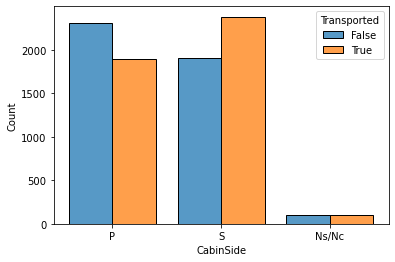

In [24]:
sns.histplot(train_data, x='CabinSide', hue='Transported', multiple='dodge', shrink=.8);

## Destination

The planet the passenger will be debarking to.

In [25]:
train_data.Destination.value_counts(dropna=False)

TRAPPIST-1e      5915
55 Cancri e      1800
PSO J318.5-22     796
NaN               182
Name: Destination, dtype: int64

In [26]:
train_data['Destination'] = train_data.Destination.astype('string').fillna('Ns/Nc')

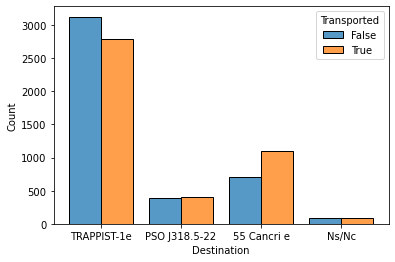

In [27]:
sns.histplot(train_data, x='Destination', hue='Transported', multiple='dodge', shrink=.8);

Se puede comprobar si tiene relación con `Cabin` por ejemplo.

## Age

The age of the passenger.

In [28]:
train_data.Age.describe()

count    8514.000000
mean       28.827930
std        14.489021
min         0.000000
25%        19.000000
50%        27.000000
75%        38.000000
max        79.000000
Name: Age, dtype: float64

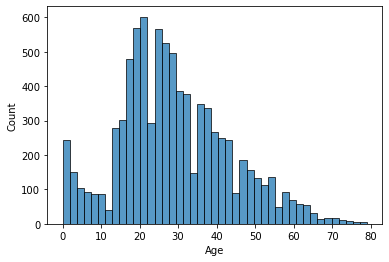

In [29]:
sns.histplot(train_data.Age);

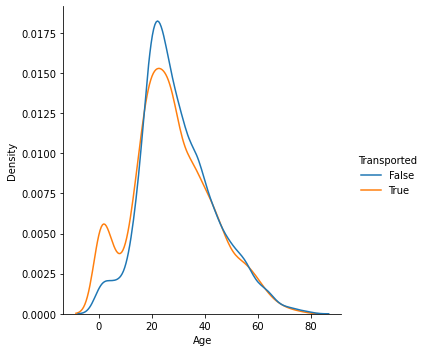

In [30]:
sns.displot(data=train_data, x="Age", hue="Transported", kind="kde");

Las mayores diferencias se ven en los pasageros más jóvenes y en los que tienen 20-30 años. Entre los primeros hay un mayor porcentaje de pasajeros perdidos, mientras que en el grupo de jóvenes hay mayor proporción de pasajeros que no fueron transportados. En el resto del espectro de edades no parece haber diferencias.train_data.Age

Posibilidad de binarizar esta variable.

In [31]:
# bins = pd.IntervalIndex.from_tuples([(0, 20), (21, 40), (41, 60), (61, 80)], closed='both')
# bins = pd.IntervalIndex.from_tuples([(0, 15), (16, 30), (31, 45), (46, 60), (61, 75), (76, 90)], closed='both')
# 'labels' no funciona con IntervalBins.
train_data['AgeBinarized'] = pd.cut(train_data.Age, bins=[-1, 15, 30, 45, 60, 75, 90], labels=["0-15", "16-30", "31-45", "46-60", "61-75", "76-90"])
train_data.AgeBinarized.value_counts(dropna=False)

16-30    3863
31-45    2260
0-15     1240
46-60     931
61-75     210
NaN       179
76-90      10
Name: AgeBinarized, dtype: int64

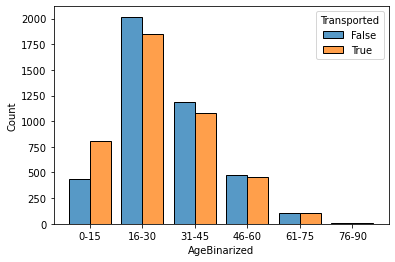

In [32]:
sns.histplot(train_data, x='AgeBinarized', hue='Transported', multiple='dodge', shrink=.8);

In [33]:
train_data['AgeBinarized'] = pd.cut(train_data.Age, bins=[-1, 20, 40, 60, 80], labels=["0-20", "20-40", "40-60", "60-80"])
train_data.AgeBinarized.value_counts(dropna=False)

20-40    4348
0-20     2435
40-60    1511
60-80     220
NaN       179
Name: AgeBinarized, dtype: int64

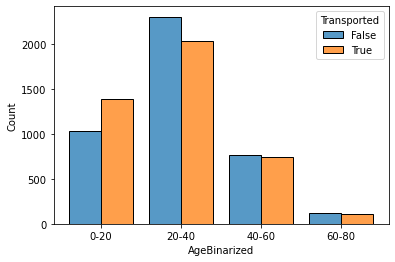

In [34]:
sns.histplot(train_data, x='AgeBinarized', hue='Transported', multiple='dodge', shrink=.8);

## VIP

Whether the passenger has paid for special VIP service during the voyage.

In [36]:
train_data.VIP.value_counts(dropna=False)

False    8291
NaN       203
True      199
Name: VIP, dtype: int64

In [38]:
train_data['VIP'] = train_data.VIP.astype('string').fillna('Ns/Nc')

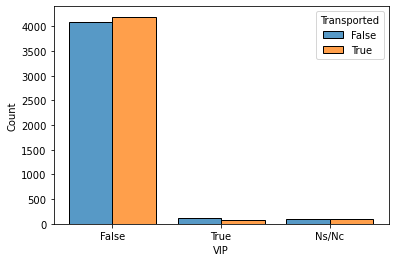

In [39]:
sns.histplot(train_data, x='VIP', hue='Transported', multiple='dodge', shrink=.8);

Las 2 clases tienen prácticamente la misma representación en clientes VIP y no VIP.

## RoomService & FoodCourt & ShoppingMall & Spa & VRDeck

Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.

In [41]:
train_data[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']].describe()

,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,224.687617,458.077203,173.729169,311.138778,304.854791
std,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,47.000000,76.000000,27.000000,59.000000,46.000000
max,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [44]:
train_data['TotalExpenses'] = train_data[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']].sum(axis=1)
train_data.TotalExpenses.describe()

count     8693.000000
mean      1440.866329
std       2803.045694
min          0.000000
25%          0.000000
50%        716.000000
75%       1441.000000
max      35987.000000
Name: TotalExpenses, dtype: float64

In [62]:
train_data.loc[train_data.TotalExpenses!=0, 'TotalExpenses'].describe()

count     5040.000000
mean      2485.208532
std       3310.148848
min          1.000000
25%        797.000000
50%       1187.500000
75%       2633.500000
max      35987.000000
Name: TotalExpenses, dtype: float64

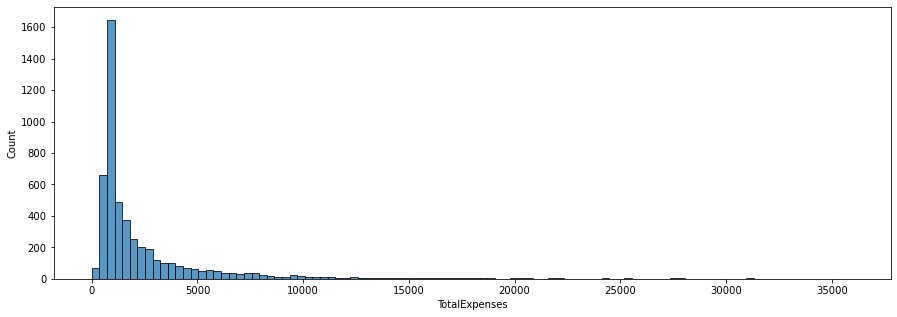

In [49]:
plt.subplots(figsize=(15,5))
sns.histplot(train_data.loc[train_data.TotalExpenses!=0, 'TotalExpenses'], bins=100);

In [74]:
quantiles = train_data.loc[train_data.TotalExpenses!=0, 'TotalExpenses'].quantile([0.33, 0.66, 0.95]).values
bins = np.append( np.insert(quantiles, 0, [0, 0.5]), np.inf )
train_data['TotalExpensesBinarized'] = pd.cut(train_data.TotalExpenses, bins, include_lowest=True, labels=["ZERO","LOW","MEDIUM","HIGH","TOP"])
train_data.TotalExpensesBinarized.value_counts(dropna=False)

ZERO      3653
LOW       1666
MEDIUM    1660
HIGH      1462
TOP        252
Name: TotalExpensesBinarized, dtype: int64

También se puede hacer esto mismo con los gastos desdoblados.

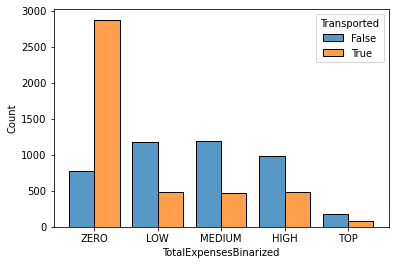

In [75]:
sns.histplot(train_data, x='TotalExpensesBinarized', hue='Transported', multiple='dodge', shrink=.8);

In [84]:
train_data.groupby('TotalExpensesBinarized')['CabinDeck'].value_counts(dropna=False)

TotalExpensesBinarized  CabinDeck
ZERO                    G            1680
                        F             654
                        B             471
                        C             323
                        E             231
                        D             109
                        Ns/Nc          97
                        A              88
LOW                     F             913
                        G             478
                        E             218
                        Ns/Nc          28
                        D              25
                        C               4
MEDIUM                  F             856
                        G             345
                        E             288
                        D             112
                        Ns/Nc          31
                        A              14
                        B               7
                        C               6
                        T               1


Está claro que los pasajeros con menos recursos no se alojaban en el `CabinDeck` 'G'.

In [89]:
train_data.groupby('TotalExpensesBinarized')['VIP'].value_counts(dropna=False, normalize=True)

TotalExpensesBinarized  VIP  
ZERO                    False    0.966877
                        Ns/Nc    0.025459
                        True     0.007665
LOW                     False    0.973589
                        Ns/Nc    0.022809
                        True     0.003601
MEDIUM                  False    0.954217
                        True     0.025301
                        Ns/Nc    0.020482
HIGH                    False    0.914501
                        True     0.064979
                        Ns/Nc    0.020520
TOP                     False    0.857143
                        True     0.111111
                        Ns/Nc    0.031746
Name: VIP, dtype: float64

La variable `TotalExpensesBinarized` está correlacionada con la variable `VIP`.

In [80]:
train_data['Expenses'] = (train_data.TotalExpenses != 0).astype('str')
train_data.Expenses.value_counts(dropna=False)

True     5040
False    3653
Name: Expenses, dtype: int64

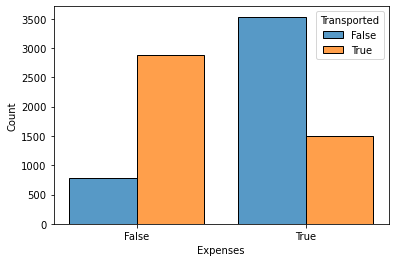

In [81]:
sns.histplot(train_data, x='Expenses', hue='Transported', multiple='dodge', shrink=.8);

Entre los pasajeros que sí tenían gastos adicionales hay una menor proporción de pasajeros perdidos que entre los que no tenían gastos adicionales. Esto probablemente esté relacionado con el nivel de renta.

## Name

The first and last names of the passenger.

In [91]:
from gender_guesser import detector
d = detector.Detector()

In [98]:
def get_sex(name):
    if pd.notna(name):
        sex = d.get_gender( name.split(' ')[0] )
        return sex if sex in ['female','male'] else 'Ns/Nc'
    else:
        return 'Ns/Nc'

train_data['Sex'] = train_data.Name.apply(get_sex)
train_data.Sex.value_counts(dropna=False)

Ns/Nc     7459
female     811
male       423
Name: Sex, dtype: int64

In [100]:
train_data.loc[train_data.Sex=='male', 'Name'].sample(5)

3740       Lorian River
8318    Timmy Garnettiz
7772          Gal Prité
2446    Paulie Stanleyd
1566        Arin Fringh
Name: Name, dtype: object

Hay ejemplos en los que se ve que la clasificación no es completamente precisa, por lo que descartamos extraer el sexo a partir del nombre. Además, en la mayoría de proyectos trabajar con el nombre es poco probable debido a la confidencialidad de los datos.

## Transported

Whether the passenger was transported to another dimension. **This is the target**, the column you are trying to predict.

In [35]:
train_data.Transported.value_counts()

True     4378
False    4315
Name: Transported, dtype: int64

Las dos clases están igualmente representadas.